# Lesson 8: Object Detection

In this lesson, you will explore computer vision models and play with some of them to build a cool application.

In particular, you will build an assistant that can help a visually impaired person understand what is in a picture. 

- In the classroom, the libraries are already installed for you.
- If you would like to run this code on your own machine, you can install the following:

```
    !pip install transformers
    !pip install gradio
    !pip install timm
    !pip install inflect
    !pip install phonemizer
```

**Note:**  `py-espeak-ng` is only available Linux operating systems.

To run locally in a Linux machine, follow these commands:
```
    sudo apt-get update
    sudo apt-get install espeak-ng
    pip install py-espeak-ng
```

### Build the `object-detection` pipeline using 🤗 Transformers Library

- This model was release with the paper [End-to-End Object Detection with Transformers](https://arxiv.org/abs/2005.12872) from Carion et al. (2020)

In [1]:
import io
import matplotlib.pyplot as plt
import requests
import inflect
from PIL import Image

In [2]:
def load_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw)

In [3]:
def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16,10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:
        x, y = prediction['box']['xmin'], prediction['box']['ymin']
        w = prediction['box']['xmax'] - prediction['box']['xmin']
        h = prediction['box']['ymax'] - prediction['box']['ymin']

        ax.add_patch(plt.Rectangle((x, y),
                                   w,
                                   h,
                                   fill=False,
                                   color="green",
                                   linewidth=2))
        ax.text(
           x,
           y,
           f"{prediction['label']}: {round(prediction['score']*100, 1)}%",
           color='red'
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png',
                bbox_inches='tight',
                pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)

    # Close the plot to prevent it from being displayed
    plt.close()

    return modified_image

In [4]:
from transformers import pipeline

- Here is some code that suppresses warning messages.

In [5]:
import warnings
import logging
from transformers import logging as hf_logging

def ignore_warnings():
    # Ignore specific Python warnings
    warnings.filterwarnings("ignore", message="Some weights of the model checkpoint")
    warnings.filterwarnings("ignore", message="Could not find image processor class")
    warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated")

    # Adjust logging for libraries using the logging module
    logging.basicConfig(level=logging.ERROR)
    hf_logging.set_verbosity_error()

In [6]:
from transformers.utils import logging
logging.set_verbosity_error()

# ignore_warnings()

In [7]:
od_pipe = pipeline("object-detection", "facebook/detr-resnet-50")

Why choose resnet50?
Because today we have many SOTA object detection models that you can use from the AI ecosystem in general. For that, you can simply browse HuggingFace and use filter "Object Detection" to download free models from the hub

Info about [facebook/detr-resnet-50](https://huggingface.co/facebook/detr-resnet-50)

Explore more of the [Hugging Face Hub for more object detection models](https://huggingface.co/models?pipeline_tag=object-detection&sort=trending)

### What is Object detection?
Task of object detection simply consists of detecting objects of interest in a specific image.

Object detection combines 2 sub-tasks, which are classification, but also localization.

### Use the Pipeline

In [8]:
from PIL import Image

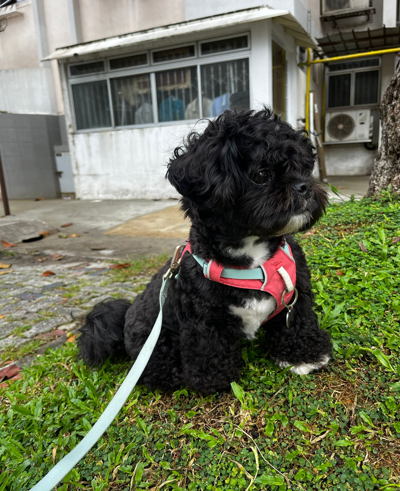

In [9]:
raw_image = Image.open('Dusty.jpeg')
raw_image.resize((400, 491))

In [10]:
pipeline_output = od_pipe(raw_image)

- Return the results from the pipeline using the helper function `render_results_in_image`.

In [11]:
processed_image = render_results_in_image(
    raw_image, 
    pipeline_output)

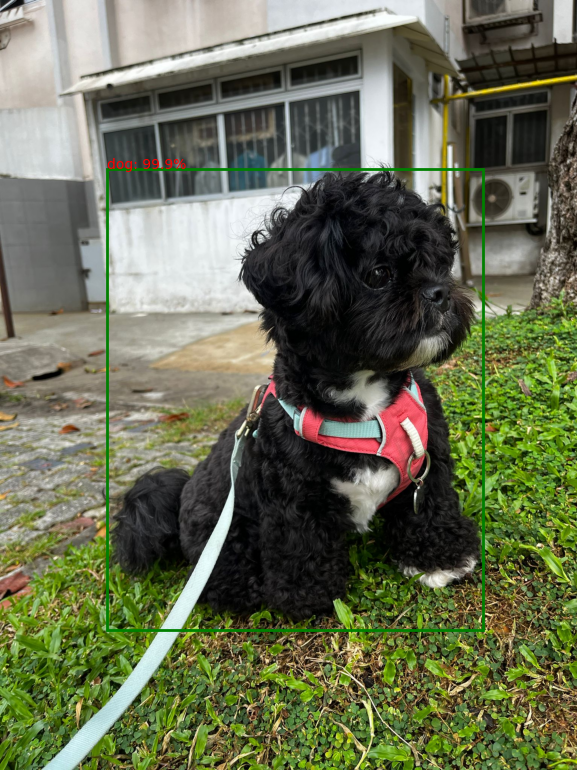

In [12]:
processed_image

### Using `Gradio` as a Simple Interface

- Use [Gradio](https://www.gradio.app) to create a demo for the object detection app.
- The demo makes it look friendly and easy to use.
- You can share the demo with your friends and colleagues as well.

In [13]:
import os
import gradio as gr

In [14]:
def get_pipeline_prediction(pil_image):
    
    pipeline_output = od_pipe(pil_image)
    
    processed_image = render_results_in_image(pil_image,
                                            pipeline_output)
    return processed_image

In [15]:
demo = gr.Interface(
  fn=get_pipeline_prediction,
  inputs=gr.Image(label="Input image", 
                  type="pil"),
  outputs=gr.Image(label="Output image with predicted instances",
                   type="pil")
)

- `share=True` will provide an online link to access to the demo

In [16]:
demo.launch(share=True) #, server_port=int(os.environ['PORT1']

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://9647d136bba4ac2cf3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [17]:
demo.close()

Closing server running on port: 7860


### Close the app
- Remember to call `.close()` on the Gradio app when you're done using it.

### Make an AI Powered Audio Assistant

- Combine the object detector with a text-to-speech model that will help dictate what is inside the image.

- Inspect the output of the object detection pipeline.

In [18]:
pipeline_output

[{'score': 0.9991838335990906,
  'label': 'dog',
  'box': {'xmin': 284, 'ymin': 449, 'xmax': 1285, 'ymax': 1674}}]

In [19]:
od_pipe

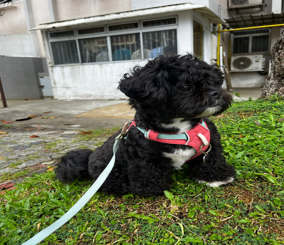

In [21]:
raw_image = Image.open('Dusty.jpeg')
raw_image.resize((284, 245))

In [22]:
def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction['label']
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are "
    for i, (label, count) in enumerate(summary.items()):
        count_string = p.number_to_words(count)
        result_string += f"{count_string} {label}"
        if count > 1:
          result_string += "s"

        result_string += " "

        if i == len(summary) - 2:
          result_string += "and "

    # Remove the trailing comma and space
    result_string = result_string.rstrip(', ') + "."

    return result_string

In [23]:
text = summarize_predictions_natural_language(pipeline_output)

In [24]:
text

'In this image, there are one dog.'

### Generate Audio Narration of an Image

In [25]:
tts_pipe = pipeline("text-to-speech",
                    model="kakao-enterprise/vits-ljs")

More info about [kakao-enterprise/vits-ljs](https://huggingface.co/kakao-enterprise/vits-ljs).

In [26]:
narrated_text = tts_pipe(text)

RuntimeError: espeak not installed on your system

### Play the Generated Audio

In [27]:
from IPython.display import Audio as IPythonAudio

In [29]:
IPythonAudio(narrated_text["audio"][0],
             rate=narrated_text["sampling_rate"])

NameError: name 'narrated_text' is not defined

### Try it yourself! 
- Try these models with other images!